# 人肝毒性数据集V2

## 预备工作

### (1)导入需要的包

In [2]:
import pandas as  pd
import numpy as np
import math
from sklearn import metrics
from sklearn import model_selection
from sklearn import decomposition
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt
from sklearn.preprocessing import label_binarize
import copy
import pandas as pd
import numpy as np
import seaborn           as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn import preprocessing
from sklearn import decomposition
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import VarianceThreshold
from sklearn import preprocessing
from tqdm import tqdm

### (2)加载数据集

In [4]:
path_V1 = r'V1_ECFP4.csv'
path_V2 = r'V2_ECFP4.csv'
path_V3 = r'V3_ECFP4.csv'

In [5]:
raw_df = pd.read_csv(path_V2)
raw_df.head()

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,6793,7358,58472,50865,23200,51293,10962,10153,874_y,label
0,0,0,0,0,0,0,0,0,0,0,...,0.367231,0.179570,0.061695,-0.099412,0.283813,-0.340380,0.224328,-0.115066,0.189834,1
1,0,1,0,0,0,0,0,0,0,0,...,0.354631,0.057300,0.094630,-0.412270,-0.105818,0.203349,0.953430,0.183600,-0.370929,1
2,0,0,0,0,0,0,0,0,0,0,...,0.609978,0.165716,1.303920,0.260526,0.295288,-1.103160,0.103670,0.689616,0.179787,1
3,0,0,0,0,0,0,0,0,0,0,...,0.101864,-0.375501,0.490118,-0.173101,0.368423,-0.230248,0.335399,0.148853,-0.120057,1
4,0,0,0,0,0,0,0,0,0,0,...,0.038717,-0.186841,0.175487,-0.338824,-0.035254,-0.236442,-0.034348,0.141268,0.032462,1


In [13]:
label = raw_df['label']
label.head()

0    1
1    1
2    1
3    1
4    1
Name: label, dtype: int64

按照说明文件中的描述，把数据的不同属性分开，其中ECFP4为离散型数据，其余为连续型数据

In [14]:
X=raw_df.iloc[:,:-1]
ECFP4 = raw_df.iloc[:,0:2048]
phychem = raw_df.iloc[:,2048:2248]
L7 = raw_df.iloc[:,2248:-1]
phychem_ECFP4 = pd.concat([phychem,ECFP4],axis=1)
# print(ECFP4.head())
# print(phychem.head())
# print(L7.head())
print(X.head())
print(X.shape)
print(ECFP4.shape)
print(phychem.shape)
print(L7.shape)
print(phychem_ECFP4.shape)

   0_x  1_x  2_x  3_x  4_x  5_x  6_x  7_x  8_x  9_x  ...      9738      6793  \
0    0    0    0    0    0    0    0    0    0    0  ...  0.204497  0.367231   
1    0    1    0    0    0    0    0    0    0    0  ...  1.727372  0.354631   
2    0    0    0    0    0    0    0    0    0    0  ...  0.276930  0.609978   
3    0    0    0    0    0    0    0    0    0    0  ...  0.271406  0.101864   
4    0    0    0    0    0    0    0    0    0    0  ...  0.025737  0.038717   

       7358     58472     50865     23200     51293     10962     10153  \
0  0.179570  0.061695 -0.099412  0.283813 -0.340380  0.224328 -0.115066   
1  0.057300  0.094630 -0.412270 -0.105818  0.203349  0.953430  0.183600   
2  0.165716  1.303920  0.260526  0.295288 -1.103160  0.103670  0.689616   
3 -0.375501  0.490118 -0.173101  0.368423 -0.230248  0.335399  0.148853   
4 -0.186841  0.175487 -0.338824 -0.035254 -0.236442 -0.034348  0.141268   

      874_y  
0  0.189834  
1 -0.370929  
2  0.179787  
3 -0.120057 

### (3)函数定义

之后会用到的绘制聚类混淆矩阵的函数

In [7]:
def show_heatmap(cm,col_names,figsize=(5, 5)):
    f, ax = plt.subplots(figsize=figsize)
    ax =  sns.heatmap(cm,cmap="YlGnBu_r",fmt="d",annot=True,ax=ax,xticklabels=col_names,yticklabels=col_names)
    ax.set_xlabel("cluster")
    ax.set_ylabel("truth")
    plt.show() 

绘制使用TSNE降维成二维数据的函数

In [8]:
def draw_scatters_in_tsne(X_reduced_df,clustering_labels_list,titles,shape = (1,1),figsize = (8,8)):
    fig_clustered_data = plt.figure(figsize=figsize)
    for i in range(len(clustering_labels_list)):
        X_tsne_frame = pd.concat([X_reduced_df,clustering_labels_list[i]], axis=1) 
        cluster_color = {-1:'gray',0:'red',1:'blue',2:'magenta',3:'yellow',4:'cyan',5:'black',6:'green', 7:'#fff0f5', 8:'#ffdab9',9:'#ffa500' }
        if X_tsne_frame['cluster'].max()>10:
            colors_clustered_data = X_tsne_frame['cluster'].map(lambda x: x*x*x)
        else:
            colors_clustered_data = X_tsne_frame['cluster'].map(cluster_color)

        # pos = str(shape[0])+str(shape[1])+str((i+1)%shape[1])
        pos = str(shape[0])+str(shape[1])+str((i+1))

        ax_clustered_data = fig_clustered_data.add_subplot(pos)
        ax_clustered_data.scatter(X_tsne_frame['tsne_1'].values,X_tsne_frame['tsne_2'].values,c=colors_clustered_data)
        ax_clustered_data.set_xlabel('Component 1')
        ax_clustered_data.set_ylabel('Component 2')
        ax_clustered_data.set_title(titles[i])

得到f1_score、recall_0、precision_1等评价指标的函数，利用这个函数的结果来评价模型与基分类器的好坏

In [9]:
# 输入分类器，获取评价标准，如accuracy、precision等
def my_cross_validate_score(estimator,X,y,cv = 5,mean = False,ret_est=False):
    kf = model_selection.StratifiedKFold(n_splits=cv)
    #存储k次训练中得到的模型与其对应的分数
    res = dict()
    accuracy = []
    f1_score = []
    auc = []
    recall_0 = []
    recall_1 = []
    precision_0 = []
    precision_1 = []
    it=1
    #进行k次训练
    for train_index, test_index in kf.split(X,y):
        # print('train_index', train_index, 'test_index', test_index)
        train_X, train_y = X.iloc[train_index],y.iloc[train_index]
        test_X, test_y = X.iloc[test_index],y.iloc[test_index]
        estimator.fit(train_X,train_y)
        clf_predict = estimator.predict(test_X)
        report = metrics.classification_report(test_y,clf_predict,output_dict=True)
        
        accuracy.append(report['accuracy'])
        f1_score.append(report['macro avg']['f1-score'])
        try:
            if isinstance(estimator, SVC) or isinstance(estimator, LinearSVC):
                score = estimator.decision_function(test_X)
                test_y_hot = label_binarize(test_y, classes=(0, 1))
                fpr, tpr, thresholds = metrics.roc_curve(test_y_hot.ravel(), score.ravel())
                auc.append(metrics.auc(fpr, tpr))
            else:
                auc.append(metrics.roc_auc_score(test_y,estimator.predict_proba(test_X)[:,1]))
        except:
            auc.append(0)
        recall_0.append(report['0']['recall'])
        recall_1.append(report['1']['recall'])
        precision_0.append(report['0']['precision'])
        precision_1.append(report['1']['precision'])
        # print("iteration",it,".....")
        it+=1
        res['accuracy'] = accuracy
        res['f1_score'] = f1_score
        res['auc'] = auc
        res['recall_0'] = recall_0
        res['recall_1'] = recall_1
        res['precision_0'] = precision_0
        res['precision_1'] = precision_1
        
    if mean:
        for key in res.keys():
            res[key] = np.mean(res[key])
    if ret_est:
        return res,estimator
    else:
        return res


设置随机种子使得结果可以复现

In [10]:
rand_state = 2022528

### (4)数据基本情况查看

In [15]:
label_df = pd.DataFrame(label.values,columns=['cluster'])
label_df.head()

,cluster
0,1
1,1
2,1
3,1
4,1


使用TSNE将数据的各类属性降维成二维并绘制图像查看数据的基本情况。

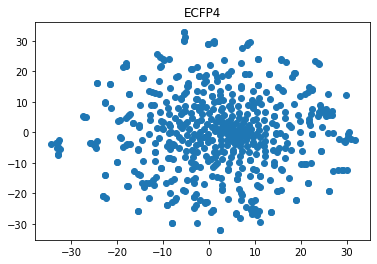

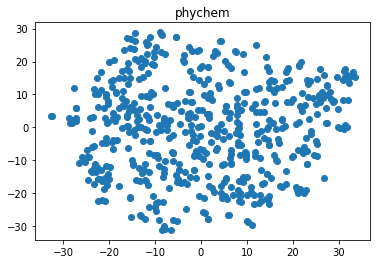

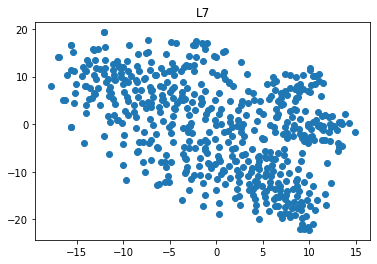

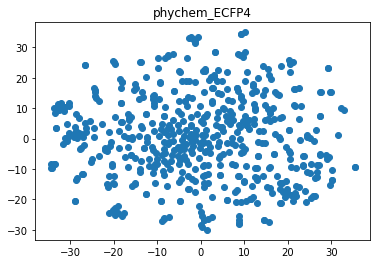

<Figure size 432x288 with 0 Axes>

In [16]:
data = [ECFP4,phychem,L7,phychem_ECFP4]
f_names = ['ECFP4','phychem','L7','phychem_ECFP4']

for f,name in zip(data,f_names):
    tsne = TSNE(n_components=2,random_state=rand_state)
    tsne.fit_transform(f)
    tsne_df = pd.DataFrame(tsne.embedding_,columns=['tsne_1','tsne_2'])
    plt.scatter(x=tsne_df['tsne_1'],y=tsne_df['tsne_2'])
    plt.title(name)
    plt.show()
    plt.clf()



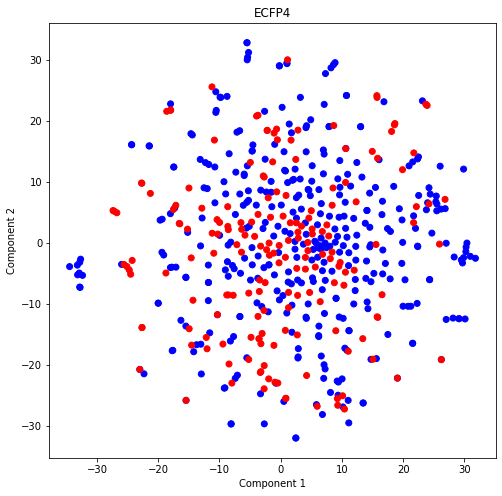

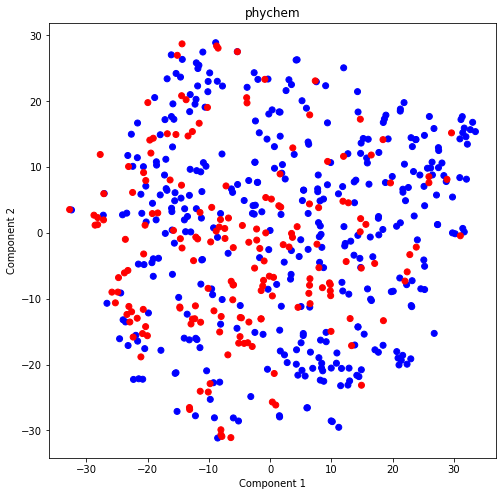

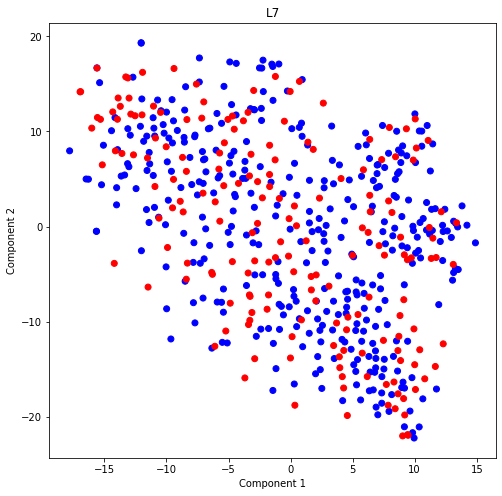

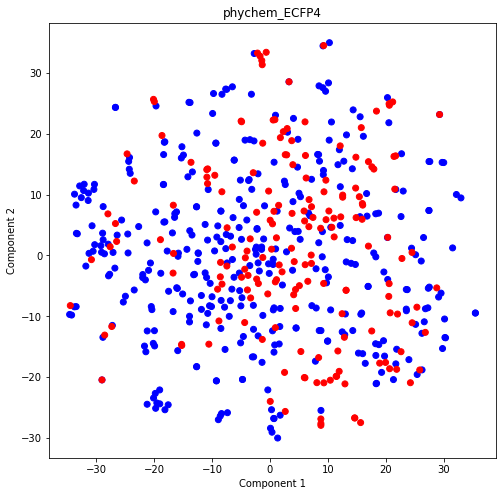

In [75]:
for f,name in zip(data,f_names):
    tsne = TSNE(n_components=2,random_state=rand_state)
    tsne.fit_transform(f)
    tsne_df = pd.DataFrame(tsne.embedding_,columns=['tsne_1','tsne_2'])
    draw_scatters_in_tsne(tsne_df,[label_df],titles=[name])

使用不同颜色标注不同的标签，从二维散点图中可以看出两类数据夹杂在一起，几乎看不出明显的聚簇。

使用sum函数求得每一个样本的ECFP4属性值的和，可以看出2000多维的属性中只有平均40个左右的1，其余全为0，ECFP4是十分稀疏的。

In [17]:
ECFP4.sum(axis=1)

0      16
1      52
2      15
3      22
4      21
       ..
549    44
550    32
551    59
552    63
553    56
Length: 554, dtype: int64

### (5)后续使用的训练数据测试数据划分

根据数据说明中的描述，将数据属性进行划分，其中测试集的大小为0.2。这个数据仅供初步测试模型性能使用，最终测试时仍使用上面提到的函数进行十折交叉验证，取其输出位最终的结果。

In [18]:
X_train_phychem, X_test_phychem, y_train_phychem, y_test_phychem = model_selection.train_test_split(phychem,label,test_size = 0.2)
X_train_ECFP4_phychem, X_test_ECFP4_phychem, y_train_ECFP4_phychem, y_test_ECFP4_phychem = model_selection.train_test_split(phychem_ECFP4,label,test_size = 0.2)
X_train_ECFP4, X_test_ECFP4, y_train_ECFP4, y_test_ECFP4 = model_selection.train_test_split(ECFP4,label,test_size = 0.2)
# X_train_ECFP4, X_test_ECFP4, y_train_ECFP4, y_test_ECFP4 = model_selection.train_test_split(ECFP4,label,test_size = 0.2)

这一份数据中包含了全部的属性。

In [19]:
# X_test.iloc[:,2248:-1]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,label,test_size = 0.1)
X_test.iloc[:,2248:-1].head()

,5720,466_y,6009,2309,387_y,3553,427_y,5898,23365,6657,...,64943,9738,6793,7358,58472,50865,23200,51293,10962,10153
55,-0.105282,-0.062533,-0.205452,-0.019369,-0.255942,-0.231431,0.202688,0.177382,0.045566,-0.042738,...,0.338033,0.082580,-0.089841,-0.112553,0.208902,-0.179678,-0.045541,-0.101763,0.385161,-0.037050
329,-0.323354,-0.464177,0.190436,-0.248748,0.775470,0.013808,0.681385,-0.426653,1.122504,0.345047,...,0.262118,0.088119,-0.301127,-1.113456,-0.936189,-0.392421,0.691013,-0.394498,0.433843,0.613905
50,0.498839,-0.563608,-1.546347,-0.886613,-0.278694,-0.453120,1.154923,-0.367472,-0.077632,-0.375049,...,-2.055068,2.176915,-0.119695,-0.062970,0.232973,1.336448,-0.166813,-1.371525,2.765948,0.157608
184,-0.398690,-0.307042,-0.144026,-0.018383,-0.180916,0.614746,0.189477,-0.127681,0.023744,0.398428,...,-0.460604,-0.060025,0.329140,-0.432663,0.023191,-0.158064,0.198725,-0.746737,-0.175553,-0.194750
449,0.232197,0.119009,0.213146,0.098524,0.297371,-0.197247,0.086431,-0.191887,-0.012693,-0.391408,...,0.103882,0.718680,-0.035717,-0.249665,-0.024924,-0.068692,-0.360696,-0.018436,-0.054086,0.195716


### (6)模型构建的一些前置工作

首先不做任何处理直接运行各个算法，查看各种算法的基本情况，根据结果选出在某些指标上突出的分类器作为集成学习的基分类器。  
由于数据集中数据包含离散型与连续型数据，所以考虑将不同类型的属性分开建模，故应该考察不同模型在不同属性上的表现。  
这里只保留了测试以ECFP4作为测试数据时的代码，查找phychem与ECFP4+phychem时将测试数据换成对应变量即可。  
将结果整理到Excel文档之中，最为选择基分类器的依据。

In [ ]:
als = [DecisionTreeClassifier(),RandomForestClassifier(),ExtraTreeClassifier(),GradientBoostingClassifier()
,xgb.XGBClassifier(probability=True,use_label_encoder=False),SVC(),LinearSVC(),KNeighborsClassifier()]
names = ['DecisionTreeClassifier','RandomForestClassifier','ExtraTreeClassifier',
'GradientBoostingClassifier','XGBClassifier','SVC','LinearSVC','KNeighborsClassifier']

for clf,name in zip(als,names):
    res = my_cross_validate_score(clf,ECFP4,label,mean=True,cv=10)
    print(name)
    print(res)

尝试引入特征选择。使用SelectFromModel算法进行自动特征选择，它通过分析数据在模型上的贡献度，将贡献度低于某个阈值(默认为所有属性贡献度的平均值)的属性剔除。

尝试将SelectFromModel与LinearSVC进行结合，为之后模型的构建进行技术验证。

In [18]:
class LinearSVC_with_feature_selection:
    def __init__(self):
        self.LinearSVC = LinearSVC()
        self.selector = None

    def fit(self,X_train,y_train):
        ECFP4 = X_train.iloc[:,0:2048]
        # phychem = X_train.iloc[:,2048:2248]
        # L7 = X_train.iloc[:,2248:]
        # phychem_ECFP4 = pd.concat([phychem,ECFP4],axis=1)
        self.selector = SelectFromModel(estimator = self.LinearSVC).fit(ECFP4, y_train)
        X_train_selected = self.selector.transform(ECFP4)
        X_train_selected = pd.DataFrame(X_train_selected)
        print(X_train_selected.shape)
        self.LinearSVC.fit(X_train_selected,y_train)

    def predict(self,X_test):
        ECFP4 = X_test.iloc[:,0:2048]
        return self.LinearSVC.predict(self.selector.transform(ECFP4))


将ECFP4进行特征抽取

In [19]:
my_cross_validate_score(LinearSVC_with_feature_selection(),X,label,cv=10,mean=True)

(498, 809)
(498, 803)
(498, 806)
(498, 793)
(499, 797)
(499, 806)
(499, 805)
(499, 798)
(499, 807)
(499, 811)


{'accuracy': 0.6426298701298702,
 'f1_score': 0.5938851936882622,
 'auc': 0.0,
 'recall_0': 0.47222222222222215,
 'recall_1': 0.7246799431009958,
 'precision_0': 0.44698565486800784,
 'precision_1': 0.7433602136885311}

## 对预分类模型的探索

尝试先对样本进行聚类，若判断为小类，则选择小类效果好的分类器对样本进行判断

寻找最佳的聚类算法对样本进行预分类。同样由于数据集包含不同类型属性，故将不同的属性分开建模，选出表现最好的模型与数据的组合。

### (1)KMeans

首先考虑的是KMeans算法，根据以往的经验将数据预先降维2维之后再进行KMeans聚类分析。

In [20]:
kmeans0 = KMeans(n_clusters=2,init="k-means++")
kmeans1 = KMeans(n_clusters=2,init="k-means++")
kmeans2 = KMeans(n_clusters=2,init="k-means++")
kmeans3 = KMeans(n_clusters=2,init="k-means++")
pca_2 = decomposition.PCA(n_components=2)

X_2d = pca_2.fit_transform(X)
ECFP4_2d = pca_2.fit_transform(ECFP4)
phychem_2d = pca_2.fit_transform(phychem)
L7_2d = pca_2.fit_transform(L7)

kmeans0.fit(X_2d)
kmeans1.fit(ECFP4_2d)
kmeans2.fit(phychem_2d)
kmeans3.fit(L7_2d)
# kmeans0.fit(X)
# kmeans1.fit(ECFP4)
# kmeans2.fit(phychem)
# kmeans3.fit(L7)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

以adjusted_rand_score得分与silhouette_score作为选择的依据

adjusted_rand_score
0.018183952905913542
0.003450455922474578
-0.005817986742173575
0.014897088455190386


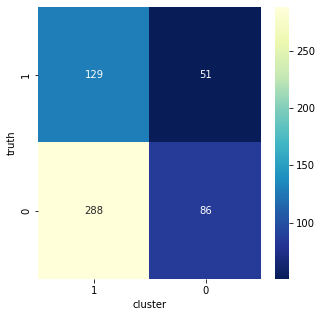

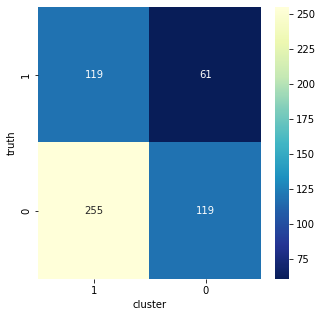

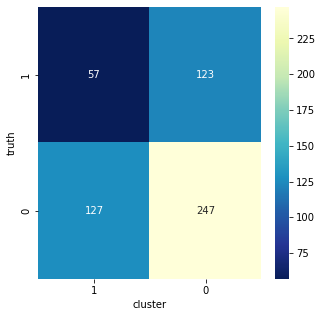

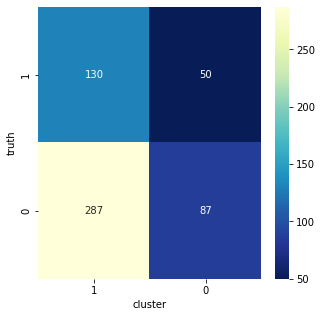

silhouette_score
0.4756124623646594
0.4053123913340878
0.42292394700199554
0.4764903084862228


In [22]:
print("adjusted_rand_score")
print(metrics.adjusted_rand_score(label,kmeans0.labels_))
print(metrics.adjusted_rand_score(label,kmeans1.labels_))
print(metrics.adjusted_rand_score(label,kmeans2.labels_))
print(metrics.adjusted_rand_score(label,kmeans3.labels_))
show_heatmap(metrics.confusion_matrix(label,kmeans0.labels_),col_names=['1','0'])
show_heatmap(metrics.confusion_matrix(label,kmeans1.labels_),col_names=['1','0'])
show_heatmap(metrics.confusion_matrix(label,kmeans2.labels_),col_names=['1','0'])
show_heatmap(metrics.confusion_matrix(label,kmeans3.labels_),col_names=['1','0'])

print("silhouette_score")
Kms_ss0=metrics.silhouette_score(X_2d,kmeans0.labels_)
Kms_ss1=metrics.silhouette_score(ECFP4_2d,kmeans1.labels_)
Kms_ss2=metrics.silhouette_score(phychem_2d,kmeans2.labels_)
Kms_ss3=metrics.silhouette_score(L7_2d,kmeans3.labels_)
print(Kms_ss0)
print(Kms_ss1)
print(Kms_ss2)
print(Kms_ss3)
# print(metrics.silhouette_score(X,kmeans0.labels_))
# print(metrics.silhouette_score(ECFP4,kmeans1.labels_))
# print(metrics.silhouette_score(phychem,kmeans2.labels_))
# print(metrics.silhouette_score(L7,kmeans3.labels_))

### (2)SpectralClustering

根据上面绘制出的数据二维散点图以及sklearn文档的描述(Few clusters, even cluster size, non-flat geometry, transductive)，我们认为SpectralClustering能得到不错的结果，所以也将SpectralClustering的聚类结果进行了研究。

In [24]:
sc0 = SpectralClustering(n_clusters=2)
sc1 = SpectralClustering(n_clusters=2)
sc2 = SpectralClustering(n_clusters=2)
sc3 = SpectralClustering(n_clusters=2)
sc0.fit(X)
sc1.fit(ECFP4)
sc2.fit(phychem)
sc3.fit(L7)

e:\anaconda\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
e:\anaconda\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
                   eigen_solver=None, eigen_tol=0.0, gamma=1.0,
                   kernel_params=None, n_clusters=2, n_components=None,
                   n_init=10, n_jobs=None, n_neighbors=10, random_state=None)

In [25]:
print("adjusted_rand_score")
print(metrics.adjusted_rand_score(label,sc0.labels_))
print(metrics.adjusted_rand_score(label,sc1.labels_))
print(metrics.adjusted_rand_score(label,sc2.labels_))
print(metrics.adjusted_rand_score(label,sc3.labels_))

print("silhouette_score")
sc_ss0=metrics.silhouette_score(X,sc0.labels_)
sc_ss1=metrics.silhouette_score(ECFP4,sc1.labels_)
sc_ss2=metrics.silhouette_score(phychem,sc2.labels_)
sc_ss3=metrics.silhouette_score(L7,sc3.labels_)
print(sc_ss0)
print(sc_ss1)
print(sc_ss2)
print(sc_ss3)

# print(sc0.labels_)
# print(sc1.labels_)
# print(sc2.labels_)
# print(sc3.labels_)

adjusted_rand_score
-0.0018707629589576843
-0.0018707629589576843
0.01364705882421066
-0.0018707629589576843
silhouette_score
0.4038893618674423
0.2484785380727736
0.1505073063033234
0.46442852967083503


### (3)投票聚类

此外，我们还尝试了在聚类时就使用投票算法，下面为将不同数据建模的KMeans算法进行投票集成的模型

In [26]:
class My_vote_cluster():
    def __init__(self):
        self.kmeans1 = KMeans(n_clusters=2,init="k-means++")
        self.kmeans2 = KMeans(n_clusters=2,init="k-means++")
        self.kmeans3 = KMeans(n_clusters=2,init="k-means++")
        self.label_ = None
    
    def ensemble_map(self,x):
        if x<=1:
            return 0;
        else:
            return 1;

    def fit(self,X_train_clus):
        X_train_ECFP4 = X_train_clus.iloc[:,0:2048]
        X_train_phychem = X_train_clus.iloc[:,2048:2248]
        X_train_L7 = X_train_clus.iloc[:,2248:-1]
        self.kmeans1.fit(X_train_ECFP4)
        self.kmeans2.fit(X_train_phychem)
        self.kmeans3.fit(X_train_L7)
        pred_df = pd.DataFrame({'label1': self.kmeans1.labels_,'label2':self.kmeans2.labels_,'label3':self.kmeans3.labels_,})
        print(pred_df)
        pred_ensemble_df = pred_df.sum(axis=1)
        print(pred_ensemble_df)
        print(pred_ensemble_df.shape)
        pred_ensemble_df = pred_ensemble_df.map(self.ensemble_map)
        self.label_ = pred_ensemble_df
        
    def predict(self,X_test_clus):
        pred1 = self.kmeans1.predict(X_test_clus)
        pred2 = self.kmeans2.predict(X_test_clus)
        pred3 = self.kmeans3.predict(X_test_clus)
        pred_df = pd.DataFrame({'pred1':pred1,'pred2':pred2,'pred3':pred3,})
        pred_ensemble_df = pred_df.sum(axis=1)
        print(pred_ensemble_df)
        pred_ensemble_df=pred_ensemble_df.map(self.ensemble_map)
        return pred_ensemble_df
        

查看投票聚类模型的表现

In [27]:
vote_clus = My_vote_cluster()
vote_clus.fit(X)
vote_label = vote_clus.label_
# print(vote_label.values)
print("adjusted_rand_score")
vc_arc = metrics.adjusted_rand_score(label,vote_label)
print(vc_arc)
print("silhouette_score")
vc_ss = metrics.silhouette_score(X,vote_label)
print(vc_ss)

     label1  label2  label3
0         0       1       0
1         0       0       1
2         0       1       1
3         0       1       0
4         0       1       0
..      ...     ...     ...
549       1       1       0
550       0       0       1
551       0       0       0
552       1       0       0
553       1       0       0

[554 rows x 3 columns]
0      1
1      1
2      2
3      1
4      1
      ..
549    2
550    1
551    0
552    1
553    1
Length: 554, dtype: int64
(554,)
adjusted_rand_score
0.0090460472084694
silhouette_score
0.09290335944668321


### (4)根据距离自定义聚类函数

自定义的聚类函数，计算出训练数据的几何中心。对于每一个测试数据，计算其与两个(共有两类标签)几何中心的距离，将它分为距离近的那一类。这样也不需要进行标签对齐。

In [28]:
class My_pre_clus():
    def __init__(self):
        self.center1=dict()
        self.center0=dict()
    
    def fit(self,X_train,y_train):
        index_1 = y_train[y_train == 1].index
        index_0 = y_train[y_train == 0].index
        ECFP4 = X_train.iloc[:,0:2048]
        phychem = X_train.iloc[:,2048:2248]
        L7 = X_train.iloc[:,2248:]
        
        ECFP4_1 = ECFP4.loc[index_1]
        ECFP4_0 = ECFP4.loc[index_0]
        phychem_1 = phychem.loc[index_1]
        phychem_0 = phychem.loc[index_0]
        L7_1 = L7.loc[index_1]
        L7_0 = L7.loc[index_0]    

        ECFP4_1_center = ECFP4_1.mean()
        ECFP4_0_center = ECFP4_0.mean()
        phychem_1_center = phychem_1.mean()
        phychem_0_center = phychem_0.mean()
        L7_1_center = L7_1.mean()
        L7_0_center = L7_0.mean()
        self.center1['ECFP4'] = ECFP4_1_center
        self.center1['phychem'] = phychem_1_center
        self.center1['L7'] = L7_1_center
        self.center0['ECFP4'] = ECFP4_0_center
        self.center0['phychem'] = phychem_0_center
        self.center0['L7'] = L7_0_center

    def eu_distance(self,cor1,cor2):
        square = 0
        for x1,x2 in zip(cor1,cor2):
            square+=math.pow((x1-x2),2)
        return math.sqrt(square)

    def predict(self,X_test):
        ECFP4 = X_test.iloc[:,0:2048]
        phychem = X_test.iloc[:,2048:2248]
        L7 = X_test.iloc[:,2248:]

        res = []
        for i in range(len(X_test)):
            vote = 0
            d1_ECFP4 = self.eu_distance(ECFP4.iloc[i],self.center1['ECFP4'])
            d0_ECFP4 = self.eu_distance(ECFP4.iloc[i],self.center0['ECFP4'])
            if d1_ECFP4<d0_ECFP4:
                vote+=1
            d1_phychem = self.eu_distance(phychem.iloc[i],self.center1['phychem'])
            d0_phychem = self.eu_distance(phychem.iloc[i],self.center0['phychem'])
            if d1_phychem<d0_phychem:
                vote+=1
            d1_L7 = self.eu_distance(L7.iloc[i],self.center1['L7'])
            d0_L7 = self.eu_distance(L7.iloc[i],self.center0['L7'])
            if d1_L7<d0_L7:
                vote+=1
            
            if vote<=1:
                res.append(0)
            else:
                res.append(1)
        return res

In [29]:
print(X_train.shape)
print(y_train.shape)

(498, 3226)
(498,)


In [30]:
my_pre_clus = My_pre_clus()
my_pre_clus.fit(X_train,y_train)
# print(my_pre_clus.center1)
# print(my_pre_clus.center0)

In [32]:
print(my_pre_clus.predict(X_test))
# print(y_test)

[1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1]


查看聚类结果。

In [33]:
print("adjusted_rand_score")
mpc_arc = metrics.adjusted_rand_score(y_test,my_pre_clus.predict(X_test))
print(mpc_arc)
print("silhouette_score")
mpc_ss = metrics.silhouette_score(X_test,my_pre_clus.predict(X_test))
print(mpc_ss)

adjusted_rand_score
0.11218994159144352
silhouette_score
0.015605622271507136


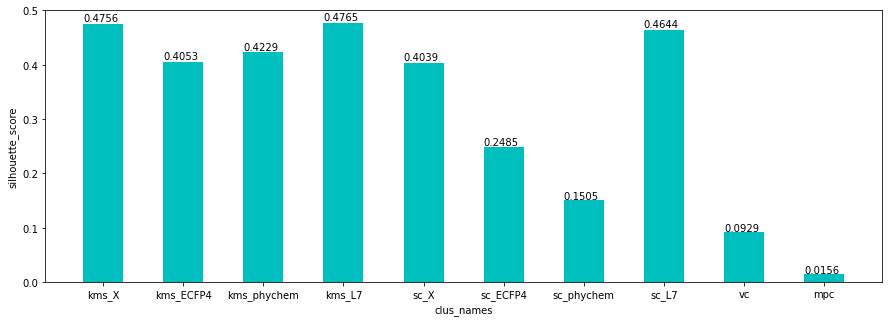

In [45]:
ss_scores = [Kms_ss0,Kms_ss1,Kms_ss2,Kms_ss3,sc_ss0,sc_ss1,sc_ss2,sc_ss3,vc_ss,mpc_ss]
clus_names = ['kms_X','kms_ECFP4','kms_phychem','kms_L7','sc_X','sc_ECFP4','sc_phychem','sc_L7','vc','mpc']

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x()+rect.get_width()/2.-0.25, 1.01*height, '%s' % round(height,4))

plt.figure(figsize=(15,5))
rects=plt.bar(clus_names,ss_scores,width=0.5,color="c")
plt.xlabel("clus_names")
plt.ylabel("silhouette_score")
autolabel(rects)

综合上述尝试的结果，我们发现使用L7属性进行建模的KMeans算法能在聚类时得到最好的结果。所以在后续的模型中使用L7建模的KMeans算法进行预分类。

## 模型的实现

有了前面工作的基础，就可以开始实现我们的模型了

### 首先是 预分类+投票 模型

In [21]:
class My_vote_clf():
    def __init__(self, topN,score = 'recall'):
        #使用phychem进行训练的基分类器
        GDBT_phychem = GradientBoostingClassifier()
        RandomForest_phychem = RandomForestClassifier()
        XGB_phychem = xgb.XGBClassifier(probability=True)
        SVC_phychem = SVC()
        KNN_phychem = KNeighborsClassifier()
        #使用ECFP4_phychem进行训练的基分类器
        RandomForest_ECFP4_phychem = RandomForestClassifier()
        ExtraTree_ECFP4_phychem = ExtraTreeClassifier()
        SVC_ECFP4_phychem = SVC()
        LinearSVC_ECFP4_phychem = LinearSVC()
        KNN_ECFP4_phychem = KNeighborsClassifier()
        #使用ECFP4进行训练的基分类器
        RandomForest_ECFP4 = RandomForestClassifier()
        GDBT_ECFP4 = GradientBoostingClassifier()
        SVC_ECFP4 = SVC()
        LinearSVC_ECFP4 = LinearSVC()
        KNN_ECFP4 = KNeighborsClassifier()
        
        self.base_als_phychem = [GDBT_phychem,RandomForest_phychem,XGB_phychem,SVC_phychem,KNN_phychem]
        self.base_als_ECFP4_phychem = [RandomForest_ECFP4_phychem,ExtraTree_ECFP4_phychem,SVC_ECFP4_phychem,LinearSVC_ECFP4_phychem,KNN_ECFP4_phychem]
        self.base_als_ECFP4 = [RandomForest_ECFP4,GDBT_ECFP4,SVC_ECFP4,LinearSVC_ECFP4,KNN_ECFP4]

        self.all_base_algo = self.base_als_phychem+self.base_als_ECFP4_phychem+self.base_als_ECFP4

        self.res_dic = dict()
        self.keys = ['accuracy','f1_score','auc','recall_0','recall_1','precision_0','precision_1']

        self.kmeans = KMeans(n_clusters=2)
        self.topN = topN
        self.score = score

    def res_map(self,x):
        thres = int(self.topN/2)
        # print(thres)
        if x<=thres:
            return 0
        else:
            return 1
        
    def fit(self,X,y):
        ECFP4 = X.iloc[:,0:2048]
        phychem = X.iloc[:,2048:2248]
        L7 = X.iloc[:,2248:]
        phychem_ECFP4 = pd.concat([phychem,ECFP4],axis=1)
        for key in self.keys:
            self.res_dic[key] = []

        for i in range(len(self.base_als_phychem)):
            temp_res = my_cross_validate_score(self.base_als_phychem[i],phychem,y,cv=10,mean=True)
            for key in self.keys:
                self.res_dic[key].append(temp_res[key])

        for i in range(len(self.base_als_ECFP4_phychem)):
            temp_res = my_cross_validate_score(self.base_als_ECFP4_phychem[i],phychem_ECFP4,y,cv=10,mean=True)
            for key in self.keys:
                self.res_dic[key].append(temp_res[key])

        for i in range(len(self.base_als_ECFP4)):
            temp_res = my_cross_validate_score(self.base_als_ECFP4[i],ECFP4,y,cv=10,mean=True)
            for key in self.keys:
                self.res_dic[key].append(temp_res[key])

        # self.kmeans.fit(L7)
        pca_2=decomposition.PCA(n_components=2)
        L7_2d = pca_2.fit_transform(L7)
        self.kmeans.fit(L7_2d)

        print(self.res_dic)
    def predict(self,X_test):
        ECFP4 = X_test.iloc[:,0:2048]
        phychem = X_test.iloc[:,2048:2248]
        L7 = X_test.iloc[:,2248:]
        phychem_ECFP4 = pd.concat([phychem,ECFP4],axis=1)
        
        if self.score in ['recall','precision']:
            clf41_index = pd.DataFrame(self.res_dic).sort_values([self.score+'_1'],ascending=False)[:self.topN].index
            clf40_index = pd.DataFrame(self.res_dic).sort_values([self.score+'_0'],ascending=False)[:self.topN].index
        else:
            clf41_index = pd.DataFrame(self.res_dic).sort_values([self.score],ascending=False)[:self.topN].index
            clf40_index = pd.DataFrame(self.res_dic).sort_values([self.score],ascending=False)[:self.topN].index 


        clf41 = []
        clf40 = []
        for i,j in zip(clf41_index,clf40_index):
            clf41.append(copy.deepcopy(self.all_base_algo[i]))
            clf40.append(copy.deepcopy(self.all_base_algo[j]))
        
        # prepred = self.kmeans.predict(L7)
        pca_2=decomposition.PCA(n_components=2)
        L7_2d = pca_2.fit_transform(L7)
        prepred = self.kmeans.predict(L7_2d)
        clf41_preds = []
        clf40_preds = []
        
        print('clf41:',clf41)
        print('clf40:',clf40)
        
        for i in range(len(clf41)):
            print('i:',i)
            print('clf41_index[i]:',clf41_index[i])
            if clf41_index[i] in range(0,5):
                clf41_preds.append(clf41[i].predict(phychem))
            elif clf41_index[i] in range(5,10):
                clf41_preds.append(clf41[i].predict(phychem_ECFP4))
            else:
                clf41_preds.append(clf41[i].predict(ECFP4))

        for i in range(len(clf40)):
            if clf40_index[i] in range(0,5):
                clf40_preds.append(clf40[i].predict(phychem))
            elif clf40_index[i] in range(5,10):
                clf40_preds.append(clf40[i].predict(phychem_ECFP4))
            else:
                clf40_preds.append(clf40[i].predict(ECFP4))

        # col_names = ['clf0','clf1','clf2','clf3','clf4']
        clf41_preds_dic = dict()
        clf40_preds_dic = dict()
        
        for i  in range(self.topN):
            key = 'clf'+str(i)
            clf41_preds_dic[key] = clf41_preds[i]
            clf40_preds_dic[key] = clf40_preds[i]
        
        clf41_preds_df = pd.DataFrame(clf41_preds_dic)
        clf40_preds_df = pd.DataFrame(clf40_preds_dic)

        clf41_voted_pred = clf41_preds_df.sum(axis=1).map(self.res_map)
        clf40_voted_pred = clf40_preds_df.sum(axis=1).map(self.res_map)
        
        res = []

        for i in range(len(prepred)):
            if prepred[i] == 1:
                res.append(clf41_voted_pred[i])
            else:
                res.append(clf40_voted_pred[i])

        print('prepred',prepred)

        print('clf41',clf41)
        print('clf40',clf40)

        print('clf41_preds_dic',clf41_preds_dic)
        print('clf40_preds_dic',clf40_preds_dic)
        
        print('clf41_voted_pred',clf41_voted_pred)
        print('clf40_voted_pred',clf40_voted_pred)

        return res        

使用之前定义的测试数据与训练数据搜索最佳的参数，这里相当于进行一折交叉验证

In [ ]:
scores = ['accuracy','precision','recall','f1_score']
topNs = range(1,6,2)
reports = []
for score in scores :
    for topN in topNs:
        reports.append("{}-{}".format(score,topN))
        my_vote_clf = My_vote_clf(topN,score=score)
        my_vote_clf.fit(X_train,y_train)
        my_vote_clf_pred =  my_vote_clf.predict(X_test)
        reports.append(metrics.classification_report(y_test,my_vote_clf_pred))

In [23]:
for report in reports:
    print(report)

accuracy-1
              precision    recall  f1-score   support

           0       0.67      0.31      0.42        13
           1       0.82      0.95      0.88        43

    accuracy                           0.80        56
   macro avg       0.74      0.63      0.65        56
weighted avg       0.78      0.80      0.77        56

accuracy-3
              precision    recall  f1-score   support

           0       0.67      0.31      0.42        13
           1       0.82      0.95      0.88        43

    accuracy                           0.80        56
   macro avg       0.74      0.63      0.65        56
weighted avg       0.78      0.80      0.77        56

accuracy-5
              precision    recall  f1-score   support

           0       0.83      0.38      0.53        13
           1       0.84      0.98      0.90        43

    accuracy                           0.84        56
   macro avg       0.84      0.68      0.71        56
weighted avg       0.84      0.84      0.

搜索结果哦显示 f1-score-5的结果最佳，故参数设置为5,score='f1_score'得到最终的结果

使用十折交叉验证得到最终的成绩

In [ ]:
my_cross_validate_score(My_vote_clf(5,score='accuracy'),X,label,cv=10,mean=True)

输出：  
{'accuracy': 0.7273701298701299,  
 'f1_score': 0.6208039498032091,  
 'auc': 0.0,  
 'recall_0': 0.31666666666666665,  
 'recall_1': 0.92524893314367,  
 'precision_0': 0.6747435897435897,  
 'precision_1': 0.7389854091713058}   

### 特征选择+预分类+投票

In [58]:
class My_vote_select_clf():
    def __init__(self, topN,score = 'recall'):
        #使用phychem进行训练的基分类器
        #KNN不支持特征选择
        GDBT_phychem = GradientBoostingClassifier()
        RandomForest_phychem = RandomForestClassifier(verbose=0)
        XGB_phychem = xgb.XGBClassifier(verbosity=0)
        SVC_phychem = SVC(kernel="linear")
        # KNN_phychem = KNeighborsClassifier()
        #使用ECFP4_phychem进行训练的基分类器
        RandomForest_ECFP4_phychem = RandomForestClassifier()
        ExtraTree_ECFP4_phychem = ExtraTreeClassifier()
        SVC_ECFP4_phychem = SVC(kernel="linear")
        LinearSVC_ECFP4_phychem = LinearSVC()
        # KNN_ECFP4_phychem = KNeighborsClassifier()
        #使用ECFP4进行训练的基分类器
        RandomForest_ECFP4 = RandomForestClassifier()
        GDBT_ECFP4 = GradientBoostingClassifier()
        SVC_ECFP4 = SVC(kernel="linear")
        LinearSVC_ECFP4 = LinearSVC()
        # KNN_ECFP4 = KNeighborsClassifier()
        
        self.base_als_phychem = [GDBT_phychem,RandomForest_phychem,XGB_phychem,SVC_phychem]
        self.base_als_ECFP4_phychem = [RandomForest_ECFP4_phychem,ExtraTree_ECFP4_phychem,SVC_ECFP4_phychem,LinearSVC_ECFP4_phychem]
        self.base_als_ECFP4 = [RandomForest_ECFP4,GDBT_ECFP4,SVC_ECFP4,LinearSVC_ECFP4]
        self.all_base_algo = self.base_als_phychem+self.base_als_ECFP4_phychem+self.base_als_ECFP4
        self.algo_names = ['GDBT_phychem','RandomForest_phychem','XGB_phychem','SVC_phychem',
        'RandomForest_ECFP4_phychem','ExtraTree_ECFP4_phychem','SVC_ECFP4_phychem','LinearSVC_ECFP4_phychem',
        'RandomForest_ECFP4','GDBT_ECFP4','SVC_ECFP4','LinearSVC_ECFP4']
        selectors = []
        for algo in self.all_base_algo:
            selectors.append(SelectFromModel(estimator = algo))
        self.algo_selector_set = list(zip(self.all_base_algo,selectors,self.algo_names))

        self.res_dic = dict()
        self.keys = ['accuracy','f1_score','auc','recall_0','recall_1','precision_0','precision_1']

        self.kmeans = KMeans(n_clusters=2)
        self.prepredictor = My_pre_clus()
        self.topN = topN
        self.score = score

    def res_map(self,x):
        thres = int(self.topN/2)
        # print(thres)
        if x<=thres:
            return 0
        else:
            return 1
        
    def fit(self,X,y):
        ECFP4 = X.iloc[:,0:2048]
        phychem = X.iloc[:,2048:2248]
        L7 = X.iloc[:,2248:]
        phychem_ECFP4 = pd.concat([phychem,ECFP4],axis=1)

        for key in self.keys:
            self.res_dic[key] = []

        for i in range(len(self.algo_selector_set)):
            t=self.algo_selector_set[i]
            print('fitting:',t[2])
            if i in range(4):
                t[1].fit(phychem,y)
                train_selected = t[1].transform(phychem)
            elif i in range(4,8):
                t[1].fit(phychem_ECFP4,y)
                train_selected = t[1].transform(phychem_ECFP4)
            else:
                t[1].fit(ECFP4,y)
                train_selected = t[1].transform(ECFP4)
            
            train_selected = pd.DataFrame(train_selected)
            temp_res = my_cross_validate_score(t[0],train_selected,y,cv=10,mean=True)
            for key in self.keys:
                self.res_dic[key].append(temp_res[key])

        pca_2=decomposition.PCA(n_components=2)
        L7_2d = pca_2.fit_transform(L7)
        self.kmeans.fit(L7_2d)
        # self.kmeans.fit(L7)
        # self.prepredictor.fit(X_train,y_train)

        print(self.res_dic)
    def predict(self,X_test):
        ECFP4 = X_test.iloc[:,0:2048]
        phychem = X_test.iloc[:,2048:2248]
        L7 = X_test.iloc[:,2248:]
        phychem_ECFP4 = pd.concat([phychem,ECFP4],axis=1)
        
        if self.score in ['recall','precision']:
            clf41_index = pd.DataFrame(self.res_dic).sort_values([self.score+'_1'],ascending=False)[:self.topN].index
            clf40_index = pd.DataFrame(self.res_dic).sort_values([self.score+'_0'],ascending=False)[:self.topN].index
        else:
            clf41_index = pd.DataFrame(self.res_dic).sort_values([self.score],ascending=False)[:self.topN].index
            clf40_index = pd.DataFrame(self.res_dic).sort_values([self.score],ascending=False)[:self.topN].index 


        clf41 = []
        clf40 = []
        for i,j in zip(clf41_index,clf40_index):
            clf41.append(copy.deepcopy(self.algo_selector_set[i]))
            clf40.append(copy.deepcopy(self.algo_selector_set[j]))
        
        pca_2=decomposition.PCA(n_components=2)
        L7_2d = pca_2.fit_transform(L7)
        prepred = self.kmeans.predict(L7_2d)
        # prepred = self.kmeans.predict(L7)
        # prepred = self.prepredictor.predict(X_test)
        clf41_preds = []
        clf40_preds = []

        for i in range(len(clf41)):
            t = clf41[i]
            if clf41_index[i] in range(0,4):
                test_data = phychem
            elif clf41_index[i] in range(4,8):
                test_data = phychem_ECFP4
            else:
                test_data = ECFP4
            clf41_preds.append(t[0].predict(t[1].transform(test_data)))

        for i in range(len(clf40)):
            t = clf40[i]
            if clf40_index[i] in range(0,4):
                test_data = phychem
            elif clf40_index[i] in range(4,8):
                test_data = phychem_ECFP4
            else:
                test_data = ECFP4
            clf40_preds.append(t[0].predict(t[1].transform(test_data)))

        # col_names = ['clf0','clf1','clf2','clf3','clf4']
        clf41_preds_dic = dict()
        clf40_preds_dic = dict()
        
        for i  in range(self.topN):
            key = 'clf'+str(i)
            clf41_preds_dic[key] = clf41_preds[i]
            clf40_preds_dic[key] = clf40_preds[i]
        
        clf41_preds_df = pd.DataFrame(clf41_preds_dic)
        clf40_preds_df = pd.DataFrame(clf40_preds_dic)

        clf41_voted_pred = clf41_preds_df.sum(axis=1).map(self.res_map)
        clf40_voted_pred = clf40_preds_df.sum(axis=1).map(self.res_map)
        
        res = []

        for i in range(len(prepred)):
            if prepred[i] == 1:
                res.append(clf41_voted_pred[i])
            else:
                res.append(clf40_voted_pred[i])

        print('prepred',prepred)

        print('clf41',clf41)
        print('clf40',clf40)

        print('clf41_preds_dic',clf41_preds_dic)
        print('clf40_preds_dic',clf40_preds_dic)
        
        print('clf41_voted_pred',clf41_voted_pred)
        print('clf40_voted_pred',clf40_voted_pred)

        return res        

寻找最佳的参数

In [ ]:
scores = ['accuracy','precision','recall','f1_score']
topNs = range(1,6,2)
reports = []
for score in scores :
    for topN in topNs:
        reports.append("{}-{}".format(score,topN))
        my_vote_clf = My_vote_select_clf(topN,score=score)
        my_vote_clf.fit(X_train,y_train)
        my_vote_clf_pred =  my_vote_clf.predict(X_test)
        reports.append(metrics.classification_report(y_test,my_vote_clf_pred))
        print("Done {}-{}".format(score,topN))

In [ ]:
for report in reports:
    print(report)

输出详情见 My_vote_select_clf 调参输出.txt

最佳参数组合为 accuracy-5

十折交叉验证得到最终的结果

In [ ]:
my_cross_validate_score(My_vote_select_clf(5,score='accuracy'),X,label,cv=10,mean=True)

输出：   
{'accuracy': 0.6731493506493507,  
 'f1_score': 0.6161528728746226,  
 'auc': 0.0,  
 'recall_0': 0.45555555555555555,  
 'recall_1': 0.7780938833570412,  
 'precision_0': 0.495771676294122,  
 'precision_1': 0.7493609400570473}   

### 上采样

由于数据由些许不均衡，所以考虑引入上采样来提升结果

In [48]:
class My_up_sampler():
    def __init__(self):
        pass
    
    def up_sample(self,X_train,y_train):
        index_1 = y_train[y_train == 1].index
        index_0 = y_train[y_train == 0].index
        X_train_0 = X_train.loc[index_0]
        y_train_0 = y_train.loc[index_0]
        scale = len(index_1)/len(index_0)
        # print('scale:',scale)
        ret_X = copy.deepcopy(X_train)
        ret_y = copy.deepcopy(y_train)
        for i in range(math.ceil(scale)-1):
            ret_X = ret_X.append(X_train_0)
            ret_y = ret_y.append(y_train_0)
        return ret_X,ret_y  


测试上采样器

In [49]:
test_index = [1,2,3,4,5,408,409]
test_df_X = X.loc[test_index]
test_df_y = label.loc[test_index]

print(test_df_X.shape)
print(test_df_y.shape)

my_up_sampler = My_up_sampler()
test_df_X,test_df_y = my_up_sampler.up_sample(test_df_X,test_df_y)
# my_up_sampler.up_sample(test_df_X,test_df_y)

print(test_df_X.shape)
print(test_df_y.shape)

(7, 3226)
(7,)
(11, 3226)
(11,)


### 特征选择+预分类+投票+上采样

SelectFromModel可使用K值来调整阈值的范围，所以我们将它设为参数，并在之后进行调参

In [55]:
class My_vote_select_with_up_sample_clf():
    def __init__(self, topN,score = 'recall',offset = 0,k=1):
        #使用phychem进行训练的基分类器
        #KNN不支持特征选择
        GDBT_phychem = GradientBoostingClassifier()
        RandomForest_phychem = RandomForestClassifier()
        XGB_phychem = xgb.XGBClassifier(verbosity=0,use_label_encoder=False)
        SVC_phychem = SVC(kernel="linear")
        # KNN_phychem = KNeighborsClassifier()
        #使用ECFP4_phychem进行训练的基分类器
        RandomForest_ECFP4_phychem = RandomForestClassifier()
        ExtraTree_ECFP4_phychem = ExtraTreeClassifier()
        SVC_ECFP4_phychem = SVC(kernel="linear")
        LinearSVC_ECFP4_phychem = LinearSVC(dual=False)
        # KNN_ECFP4_phychem = KNeighborsClassifier()
        #使用ECFP4进行训练的基分类器
        RandomForest_ECFP4 = RandomForestClassifier()
        GDBT_ECFP4 = GradientBoostingClassifier()
        SVC_ECFP4 = SVC(kernel="linear")
        LinearSVC_ECFP4 = LinearSVC(dual=False)
        # KNN_ECFP4 = KNeighborsClassifier()
        
        self.base_als_phychem = [GDBT_phychem,RandomForest_phychem,XGB_phychem,SVC_phychem]
        self.base_als_ECFP4_phychem = [RandomForest_ECFP4_phychem,ExtraTree_ECFP4_phychem,SVC_ECFP4_phychem,LinearSVC_ECFP4_phychem]
        self.base_als_ECFP4 = [RandomForest_ECFP4,GDBT_ECFP4,SVC_ECFP4,LinearSVC_ECFP4]
        self.all_base_algo = self.base_als_phychem+self.base_als_ECFP4_phychem+self.base_als_ECFP4
        self.algo_names = ['GDBT_phychem','RandomForest_phychem','XGB_phychem','SVC_phychem',
        'RandomForest_ECFP4_phychem','ExtraTree_ECFP4_phychem','SVC_ECFP4_phychem','LinearSVC_ECFP4_phychem',
        'RandomForest_ECFP4','GDBT_ECFP4','SVC_ECFP4','LinearSVC_ECFP4']
        selectors = []
        self.k = k
        threshold = "{}*mean".format(self.k)
        for algo in self.all_base_algo:
            selectors.append(SelectFromModel(estimator = algo,threshold=threshold))
        self.algo_selector_set = list(zip(self.all_base_algo,selectors,self.algo_names))

        self.res_dic = dict()
        self.keys = ['accuracy','f1_score','auc','recall_0','recall_1','precision_0','precision_1']

        self.kmeans = KMeans(n_clusters=2)
        self.prepredictor = My_pre_clus()
        self.topN = topN
        self.score = score
        self.offset = offset

    def res_map(self,x):
        thres = int(self.topN/2)+self.offset
        # print(thres)
        if x<=thres:
            return 0
        else:
            return 1
        
    def fit(self,X_train,y_train):
        my_up_sampler = My_up_sampler()
        # print('X_train.shape',X_train.shape)
        # print('y_train.shape',y_train.shape)
        X,y = my_up_sampler.up_sample(X_train,y_train)
        # print(X.shape)
        # print(y.shape)
        ECFP4 = X.iloc[:,0:2048]
        phychem = X.iloc[:,2048:2248]
        L7 = X.iloc[:,2248:]
        phychem_ECFP4 = pd.concat([phychem,ECFP4],axis=1)

        for key in self.keys:
            self.res_dic[key] = []

        for i in range(len(self.algo_selector_set)):
            t=self.algo_selector_set[i]
            # print('fitting:',t[2])
            if i in range(4):
                t[1].fit(phychem,y)
                train_selected = t[1].transform(phychem)
            elif i in range(4,8):
                t[1].fit(phychem_ECFP4,y)
                train_selected = t[1].transform(phychem_ECFP4)
            else:
                t[1].fit(ECFP4,y)
                train_selected = t[1].transform(ECFP4)
            
            train_selected = pd.DataFrame(train_selected)
            temp_res = my_cross_validate_score(t[0],train_selected,y,cv=10,mean=True)
            for key in self.keys:
                self.res_dic[key].append(temp_res[key])

        pca_2=decomposition.PCA(n_components=2)
        L7_2d = pca_2.fit_transform(L7)
        self.kmeans.fit(L7_2d)
        # self.kmeans.fit(L7)
        # self.prepredictor.fit(X_train,y_train)

        # print(self.res_dic)
    def predict(self,X_test):
        ECFP4 = X_test.iloc[:,0:2048]
        phychem = X_test.iloc[:,2048:2248]
        L7 = X_test.iloc[:,2248:]
        phychem_ECFP4 = pd.concat([phychem,ECFP4],axis=1)
        
        if self.score in ['recall','precision']:
            clf41_index = pd.DataFrame(self.res_dic).sort_values([self.score+'_1'],ascending=False)[:self.topN].index
            clf40_index = pd.DataFrame(self.res_dic).sort_values([self.score+'_0'],ascending=False)[:self.topN].index
        else:
            clf41_index = pd.DataFrame(self.res_dic).sort_values([self.score],ascending=False)[:self.topN].index
            clf40_index = pd.DataFrame(self.res_dic).sort_values([self.score],ascending=False)[:self.topN].index 


        clf41 = []
        clf40 = []
        for i,j in zip(clf41_index,clf40_index):
            clf41.append(copy.deepcopy(self.algo_selector_set[i]))
            clf40.append(copy.deepcopy(self.algo_selector_set[j]))
        
        pca_2=decomposition.PCA(n_components=2)
        L7_2d = pca_2.fit_transform(L7)
        prepred = self.kmeans.predict(L7_2d)
        # prepred = self.kmeans.predict(L7)
        # prepred = self.prepredictor.predict(X_test)
        clf41_preds = []
        clf40_preds = []

        for i in range(len(clf41)):
            t = clf41[i]
            if clf41_index[i] in range(0,4):
                test_data = phychem
            elif clf41_index[i] in range(4,8):
                test_data = phychem_ECFP4
            else:
                test_data = ECFP4
            clf41_preds.append(t[0].predict(t[1].transform(test_data)))

        for i in range(len(clf40)):
            t = clf40[i]
            if clf40_index[i] in range(0,4):
                test_data = phychem
            elif clf40_index[i] in range(4,8):
                test_data = phychem_ECFP4
            else:
                test_data = ECFP4
            clf40_preds.append(t[0].predict(t[1].transform(test_data)))

        # col_names = ['clf0','clf1','clf2','clf3','clf4']
        clf41_preds_dic = dict()
        clf40_preds_dic = dict()
        
        for i  in range(self.topN):
            key = 'clf'+str(i)
            clf41_preds_dic[key] = clf41_preds[i]
            clf40_preds_dic[key] = clf40_preds[i]
        
        clf41_preds_df = pd.DataFrame(clf41_preds_dic)
        clf40_preds_df = pd.DataFrame(clf40_preds_dic)

        clf41_voted_pred = clf41_preds_df.sum(axis=1).map(self.res_map)
        clf40_voted_pred = clf40_preds_df.sum(axis=1).map(self.res_map)
        
        res = []

        for i in range(len(prepred)):
            if prepred[i] == 1:
                res.append(clf41_voted_pred[i])
            else:
                res.append(clf40_voted_pred[i])

        # print('prepred',prepred)
        # print('clf41',clf41)
        # print('clf40',clf40)
        # print('clf41_preds_dic',clf41_preds_dic)
        # print('clf40_preds_dic',clf40_preds_dic)
        # print('clf41_voted_pred',clf41_voted_pred)
        # print('clf40_voted_pred',clf40_voted_pred)
        return res        

寻找最佳参数

In [ ]:
scores = ['precision','recall']
krange = np.arange(0.8,1.3,0.05)
topNs = range(1,6,2)
reports = []

for score in scores:
    for topN in topNs:
        for k in krange:
            reports.append("{}-{}".format(score,topN))
            my_vote_clf = My_vote_select_with_up_sample_clf(topN,score=score,k=k)
            my_vote_clf.fit(X_train,y_train)
            my_vote_clf_pred =  my_vote_clf.predict(X_test)
            reports.append(metrics.classification_report(y_test,my_vote_clf_pred))
            print("Done {}-{}-{}".format(score,topN,k))
for report in reports:
    print(report)


输出详情见 My_vote_select_with_up_sample_clf调参输出.txt  

对单次验证成绩较好的参数使用十折交叉验证

In [51]:
paras = [('precision',1,0.85),('precision',3,0.9),('precision',5,1.1),('recall',3,0.85),('recall',3,0.95),('recall',5,0.8)]

十折交叉验证

In [56]:
reports = []
for t in  tqdm(paras):
    report =  my_cross_validate_score(My_vote_select_with_up_sample_clf(t[1],score=t[0],k=t[2]),X,label,cv = 10,mean=True)
    reports.append(report)


100%|██████████| 6/6 [41:07<00:00, 411.26s/it]


In [57]:
for report in reports:
    print(report)

{'accuracy': 0.6912987012987013, 'f1_score': 0.6478879624998242, 'auc': 0.0, 'recall_0': 0.5444444444444445, 'recall_1': 0.7620910384068279, 'precision_0': 0.531557310078982, 'precision_1': 0.7799827938570332}
{'accuracy': 0.6732467532467532, 'f1_score': 0.6242415420351847, 'auc': 0.0, 'recall_0': 0.5055555555555555, 'recall_1': 0.754054054054054, 'precision_0': 0.49850925682504627, 'precision_1': 0.7635529802035759}
{'accuracy': 0.7022077922077923, 'f1_score': 0.6505699486738523, 'auc': 0.0, 'recall_0': 0.5166666666666666, 'recall_1': 0.7919630156472263, 'precision_0': 0.5580092422197686, 'precision_1': 0.7768211127692758}
{'accuracy': 0.7091558441558441, 'f1_score': 0.6593000644996472, 'auc': 0.0, 'recall_0': 0.5166666666666666, 'recall_1': 0.801778093883357, 'precision_0': 0.5582622421438211, 'precision_1': 0.7770710282401364}
{'accuracy': 0.7038636363636364, 'f1_score': 0.6543814492221692, 'auc': 0.0, 'recall_0': 0.5166666666666668, 'recall_1': 0.793954480796586, 'precision_0': 0.5

### 尝试选择出最佳的特征选择阈值

尝试使用LassoCV()自动选择出最适合当前分类器的特征选择阈值，但是由于自动选择出的阈值可能使训练数据中的所有属性都被剔除，原因未知，尝试解决之后无果，故放弃。

In [116]:
from sklearn.linear_model import LassoCV
def getBestThresholdForSelectFromModel(X, y, cv=5):
    print("finding best threshold for SelectFromModel...")
    # estimator = estimator()
    clf = LassoCV(cv=cv).fit(X, y)
    importance = np.abs(clf.coef_)
    coef = pd.Series(importance, index=X.columns)
    sort_res = coef.sort_values()
    threshold = sort_res[len(sort_res) - 1]
    return threshold


In [120]:
class My_vote_LassoSelect_with_up_sample_clf():
    def __init__(self, topN,score = 'recall',offset = 0):
        #使用phychem进行训练的基分类器
        #KNN不支持特征选择
        GDBT_phychem = GradientBoostingClassifier()
        RandomForest_phychem = RandomForestClassifier()
        XGB_phychem = xgb.XGBClassifier(verbosity=0,use_label_encoder=False)
        SVC_phychem = SVC(kernel="linear")
        # KNN_phychem = KNeighborsClassifier()
        #使用ECFP4_phychem进行训练的基分类器
        RandomForest_ECFP4_phychem = RandomForestClassifier()
        ExtraTree_ECFP4_phychem = ExtraTreeClassifier()
        SVC_ECFP4_phychem = SVC(kernel="linear")
        LinearSVC_ECFP4_phychem = LinearSVC()
        # KNN_ECFP4_phychem = KNeighborsClassifier()
        #使用ECFP4进行训练的基分类器
        RandomForest_ECFP4 = RandomForestClassifier()
        GDBT_ECFP4 = GradientBoostingClassifier()
        SVC_ECFP4 = SVC(kernel="linear")
        LinearSVC_ECFP4 = LinearSVC()
        # KNN_ECFP4 = KNeighborsClassifier()
        
        self.base_als_phychem = [GDBT_phychem,RandomForest_phychem,XGB_phychem,SVC_phychem]
        self.base_als_ECFP4_phychem = [RandomForest_ECFP4_phychem,ExtraTree_ECFP4_phychem,SVC_ECFP4_phychem,LinearSVC_ECFP4_phychem]
        self.base_als_ECFP4 = [RandomForest_ECFP4,GDBT_ECFP4,SVC_ECFP4,LinearSVC_ECFP4]
        self.all_base_algo = self.base_als_phychem+self.base_als_ECFP4_phychem+self.base_als_ECFP4
        self.algo_names = ['GDBT_phychem','RandomForest_phychem','XGB_phychem','SVC_phychem',
        'RandomForest_ECFP4_phychem','ExtraTree_ECFP4_phychem','SVC_ECFP4_phychem','LinearSVC_ECFP4_phychem',
        'RandomForest_ECFP4','GDBT_ECFP4','SVC_ECFP4','LinearSVC_ECFP4']
        selectors = []
        for algo in self.all_base_algo:
            selectors.append(SelectFromModel(estimator = algo))
        self.algo_selector_set = list(zip(self.all_base_algo,selectors,self.algo_names))

        self.res_dic = dict()
        self.keys = ['accuracy','f1_score','auc','recall_0','recall_1','precision_0','precision_1']

        self.kmeans = KMeans(n_clusters=2)
        self.prepredictor = My_pre_clus()
        self.topN = topN
        self.score = score
        self.offset = offset

    def res_map(self,x):
        thres = int(self.topN/2)+self.offset
        # print(thres)
        if x<=thres:
            return 0
        else:
            return 1
        
    def fit(self,X_train,y_train):
        my_up_sampler = My_up_sampler()
        # print('X_train.shape',X_train.shape)
        # print('y_train.shape',y_train.shape)
        X,y = my_up_sampler.up_sample(X_train,y_train)
        # print(X.shape)
        # print(y.shape)
        ECFP4 = X.iloc[:,0:2048]
        phychem = X.iloc[:,2048:2248]
        L7 = X.iloc[:,2248:]
        phychem_ECFP4 = pd.concat([phychem,ECFP4],axis=1)

        for key in self.keys:
            self.res_dic[key] = []

        for i in range(len(self.algo_selector_set)):
            t=self.algo_selector_set[i]

            # print('fitting:',t[2])
            if i in range(4):
                t[1].threshold = getBestThresholdForSelectFromModel(phychem,y)
                t[1].fit(phychem,y)
                train_selected = t[1].transform(phychem)
            elif i in range(4,8):
                t[1].threshold = getBestThresholdForSelectFromModel(phychem_ECFP4,y)
                t[1].fit(phychem_ECFP4,y)
                train_selected = t[1].transform(phychem_ECFP4)
            else:
                t[1].threshold = getBestThresholdForSelectFromModel(ECFP4,y)
                t[1].fit(ECFP4,y)
                train_selected = t[1].transform(ECFP4)
            
            train_selected = pd.DataFrame(train_selected)
            print('train_selected',train_selected.shape)
            temp_res = my_cross_validate_score(t[0],train_selected,y,cv=10,mean=True)
            for key in self.keys:
                self.res_dic[key].append(temp_res[key])

        self.kmeans.fit(L7)
        # self.prepredictor.fit(X_train,y_train)

        # print(self.res_dic)
    def predict(self,X_test):
        ECFP4 = X_test.iloc[:,0:2048]
        phychem = X_test.iloc[:,2048:2248]
        L7 = X_test.iloc[:,2248:]
        phychem_ECFP4 = pd.concat([phychem,ECFP4],axis=1)
        
        if self.score in ['recall','precision']:
            clf41_index = pd.DataFrame(self.res_dic).sort_values([self.score+'_1'],ascending=False)[:self.topN].index
            clf40_index = pd.DataFrame(self.res_dic).sort_values([self.score+'_0'],ascending=False)[:self.topN].index
        else:
            clf41_index = pd.DataFrame(self.res_dic).sort_values([self.score],ascending=False)[:self.topN].index
            clf40_index = pd.DataFrame(self.res_dic).sort_values([self.score],ascending=False)[:self.topN].index 


        clf41 = []
        clf40 = []
        for i,j in zip(clf41_index,clf40_index):
            clf41.append(copy.deepcopy(self.algo_selector_set[i]))
            clf40.append(copy.deepcopy(self.algo_selector_set[j]))
        
        prepred = self.kmeans.predict(L7)
        # prepred = self.prepredictor.predict(X_test)
        clf41_preds = []
        clf40_preds = []

        for i in range(len(clf41)):
            t = clf41[i]
            if clf41_index[i] in range(0,4):
                test_data = phychem
            elif clf41_index[i] in range(4,8):
                test_data = phychem_ECFP4
            else:
                test_data = ECFP4
            clf41_preds.append(t[0].predict(t[1].transform(test_data)))

        for i in range(len(clf40)):
            t = clf40[i]
            if clf40_index[i] in range(0,4):
                test_data = phychem
            elif clf40_index[i] in range(4,8):
                test_data = phychem_ECFP4
            else:
                test_data = ECFP4
            clf40_preds.append(t[0].predict(t[1].transform(test_data)))

        # col_names = ['clf0','clf1','clf2','clf3','clf4']
        clf41_preds_dic = dict()
        clf40_preds_dic = dict()
        
        for i  in range(self.topN):
            key = 'clf'+str(i)
            clf41_preds_dic[key] = clf41_preds[i]
            clf40_preds_dic[key] = clf40_preds[i]
        
        clf41_preds_df = pd.DataFrame(clf41_preds_dic)
        clf40_preds_df = pd.DataFrame(clf40_preds_dic)

        clf41_voted_pred = clf41_preds_df.sum(axis=1).map(self.res_map)
        clf40_voted_pred = clf40_preds_df.sum(axis=1).map(self.res_map)
        
        res = []

        for i in range(len(prepred)):
            if prepred[i] == 1:
                res.append(clf41_voted_pred[i])
            else:
                res.append(clf40_voted_pred[i])

        # print('prepred',prepred)
        # print('clf41',clf41)
        # print('clf40',clf40)
        # print('clf41_preds_dic',clf41_preds_dic)
        # print('clf40_preds_dic',clf40_preds_dic)
        # print('clf41_voted_pred',clf41_voted_pred)
        # print('clf40_voted_pred',clf40_voted_pred)
        return res        

In [121]:
my_cross_validate_score(My_vote_LassoSelect_with_up_sample_clf(1),X,label,cv=10,mean=True)

scale: 2.074074074074074
finding best threshold for SelectFromModel...


e:\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0413148870384461, tolerance: 0.01264931506849316
  tol, rng, random, positive)
e:\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0579725406066558, tolerance: 0.01264931506849316
  tol, rng, random, positive)
e:\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06260165835120546, tolerance: 0.01264931506849316
  tol, rng, random, positive)
e:\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iteration

train_selected (822, 0)


e:\anaconda\lib\site-packages\sklearn\feature_selection\_base.py:81: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  UserWarning)


ValueError: at least one array or dtype is required